In [1]:
import re

from konlpy.tag import Okt,Mecab
from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd

from tqdm import tqdm
import operator

import networkx as nx
import matplotlib.pyplot as plt

Data preprocessing

In [2]:
def clean_text(text):
    cleaned_text = re.sub('[^ ㄱ-ㅣ가-힣]+',' ',text) # 한국어, 스페이스바를 제외한 모든 문자 제거
    cleaned_text = ' '.join(cleaned_text.split()) # 너무 많은 공백이 생기므로 공백 1개로
    return cleaned_text

def get_nouns(text):
    okt = Okt() # 형태소 분석기
    nouns = okt.nouns(text) # 명사 추출
    nouns = [word for word in nouns if not (word in stopwords)] # 불용어 제거
    nouns = [word for word in nouns if len(word)>1] # 길이가 1 이상만 추출
    return nouns

In [3]:
def clean_tokenizing(data):
    data = data.dropna() # 결측값 제거
    data['내용'] = data['내용'].apply(lambda x: clean_text(x)) # 한국어만 추출
    data['명사'] = data['내용'].apply(lambda x: get_nouns(x)) # 명사만 추출
    
    drop_index_list = [] # 지워버릴 index를 담는 리스트
    for i, row in data.iterrows():
        temp_nouns = row['명사']
        if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
            drop_index_list.append(i) # 지울 index 추가
    data = data.drop(drop_index_list) # 해당 index를 지우기
    data.index = range(len(data))
    return data

In [4]:
def mk_tfidf(data):
    cv = CountVectorizer(max_features=1000, tokenizer=get_nouns) # data의 tf-idf 구축, tokenizer로 get_nouns 사용
    tdm = cv.fit_transform(data['내용']) # 위의 파라미터 수에 맞게 tdm 생성
    dataset = pd.DataFrame(data=tdm.todense(),columns=cv.get_feature_names())
    return dataset

In [5]:
def mk_input(tf_idf):
    column_list = list(tf_idf.columns)
    word_length = len(column_list)

    # 각 단어쌍의 빈도수를 저장할 dictionary 생성
    count_dict = {}

    for doc_number in tqdm(range(len(tf_idf)), desc='단어쌍 만들기 진행중'):
        tmp = tf_idf.loc[doc_number]           # 현재 문서의 단어 출현 빈도 데이터를 가져온다.
        for i, word1 in enumerate(column_list):
            if tmp[word1]:              # 현재 문서에 첫번째 단어가 존재할 경우
                for j in range(i + 1, word_length):
                    if tmp[column_list[j]]:              # 현재 문서에 두번째 단어가 존재할 경우
                        count_dict[column_list[i], column_list[j]] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

    # count_list에 word1, word2, frequency 형태로 저장할 것이다.
    count_list = []

    for words in count_dict:
        count_list.append([words[0], words[1], count_dict[words]])

    # 단어쌍 동시 출현 빈도를 DataFrame 형식으로 만든다.
    df = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
    df = df.sort_values(by=['freq'], ascending=False)
    df = df.reset_index(drop=True)
    return df

감성사전에 따른 가중치 추가해야함

In [34]:
def draw(df,sent, keywords, length):
    # 폰트설정
    font_family='NanumSquareRound'
    cmap ='jet'
    
    print(keywords, length)
    dataset = pd.DataFrame()
    
    # 데이터 셋에서 키워드 추출
    for keyword in keywords:
        dataset = pd.concat([dataset, df[df['word1']==keyword][:length]])
    print(dataset)
    G_centrality = nx.Graph()

    # 데이터 셋에 관하여 엣지 추가
    for ind in list(dataset.index):
        G_centrality.add_edge(dataset['word1'][ind], dataset['word2'][ind], weight=int(dataset['freq'][ind]))

    dgr = nx.degree_centrality(G_centrality)        # 연결 중심성
    btw = nx.betweenness_centrality(G_centrality)   # 매개 중심성
    cls = nx.closeness_centrality(G_centrality)     # 근접 중심성
    egv = nx.eigenvector_centrality(G_centrality)   # 고유벡터 중심성
    pgr = nx.pagerank(G_centrality)                 # 페이지 랭크

    sorted_dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)
    sorted_btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)
    sorted_cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)
    sorted_egv = sorted(egv.items(), key=operator.itemgetter(1), reverse=True)
    sorted_pgr = sorted(pgr.items(), key=operator.itemgetter(1), reverse=True)

    G = nx.Graph()
    
    for i in range(len(sorted_pgr)): # 페이지 랭크에 따른 노드 추가, 노드 사이즈는 연결 중심성으로 결정
        G.add_node(sorted_pgr[i][0], nodesize=sorted_dgr[i][1],color='r')

    for ind in list(dataset.index): # 같이 나온 빈도수가 많을 수록 가까움
        G.add_weighted_edges_from([(dataset['word1'][ind], dataset['word2'][ind], int(dataset['freq'][ind]))])
        
        
    # 단어별 감성 점수 추출
    words = list(G.nodes)
    sent_points = []
    word_points = {}
    for word in words:
        try: # 감성 사전에 단어가 있다면
            sent_point = float(sent[sent['단어'] == word]['points'].values)
            word_points[word] = sent_point
            sent_points.append(0.5 + (sent_point/2))
        except: # 감성 사전에 단어가 없다면 0점
            word_points[word] = 0
            sent_points.append(0.5) 
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
    
    # 노드 크기 조정
    sizes = [G.nodes[node]['nodesize'] * 5000+1000 for node in G] 

    # 옵션
    options = {
        'edge_color': '#000000',
        'width': 1,
        'with_labels': True,
        'font_weight': 'regular',
        'cmap' : cmap,
        'node_color' : sent_points,
        'alpha' : 0.5
    }


    plt.figure(figsize=(10,10))
    nx.draw(G, node_size=sizes,
            pos=nx.spring_layout(G, k=3.5, iterations=100), **options, font_family=font_family)  # font_family로 폰트 등록
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#555555")
    plt.colorbar(sm)
    plt.show()
    return word_points

In [33]:
def words_freq_update():
    stopwords_path = './data/stopwords.txt'
    sent = pd.read_csv('./data/dict.csv',encoding='cp949')
    with open(stopwords_path,'r') as op:
        stopwords = op.readlines()
        stopwords = stopwords[0].split(',')

    news = pd.concat([pd.read_csv('Data/crawling data/친환경_news.csv',encoding='cp949'),pd.read_csv('Data/crawling data/환경오염_news.csv',encoding='cp949')])
    news_data = clean_tokenizing(news)
    news_tf_idf = mk_tfidf(news_data)
    news_words_freq = mk_input(news_tf_idf)
    news_words_freq.to_csv('./Data/news_words_freq.csv',encoding='cp949')


    community = pd.concat([pd.read_csv('Data/crawling data/친환경_community.csv',encoding='cp949'),pd.read_csv('Data/crawling data/환경오염_community.csv')])
    community_data = clean_tokenizing(community)
    community_tf_idf = mk_tfidf(community_data)
    community_words_freq = mk_input(community_tf_idf)
    community_words_freq.to_csv('./Data/community_words_freq.csv',encoding='cp949')


    sns = pd.concat([pd.read_csv('Data/crawling data/친환경_sns.csv'),pd.read_csv('Data/crawling data/환경오염_sns.csv')])
    sns_data = clean_tokenizing(sns)
    sns_tf_idf = mk_tfidf(sns_data)
    sns_words_freq = mk_input(sns_tf_idf)
    sns_words_freq.to_csv('./Data/sns_words_freq.csv',encoding='cp949')


연관 출현 빈도 분석결과 저장시

* * *

### 뉴스, 기사, sns를 따로 할 때

In [7]:
dict_data_path = './Data/dict.csv'
file_path = './Data/stopwords.txt'

sent_dict = pd.read_csv(dict_data_path,encoding='cp949')
with open(file_path,'r') as op:
    stopwords = op.readlines()
    stopwords = stopwords[0].split(',')

# 시각화에 필요한 단어 빈도수 그래프
news_data = pd.read_csv('./Data/news_words_freq.csv',encoding='cp949')
community_data = pd.read_csv('./Data/community_words_freq.csv',encoding='cp949')
sns_data = pd.read_csv('./Data/sns_words_freq.csv',encoding='cp949')

['환경오염', '친환경'] 10
       Unnamed: 0 word1 word2  freq
1135         1135  환경오염    활동   350
1796         1796  환경오염    활용   294
11271       11271  환경오염    효과   130
15105       15105  환경오염   황교익   111
15342       15342  환경오염    훼손   110
21805       21805  환경오염    효율    91
38663       38663  환경오염    회장    67
57020       57020  환경오염    회수    53
68467       68467  환경오염    회의    47
75673       75673  환경오염   환경청    44
1               1   친환경    환경  1836
26             26   친환경    탄소  1087
33             33   친환경  플라스틱  1022
60             60   친환경    확대   940
76             76   친환경    활용   886
106           106   친환경    한국   805
165           165   친환경    투자   684
183           183   친환경    협약   666
246           246   친환경    활동   598
262           262   친환경    현재   591


C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\python_anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


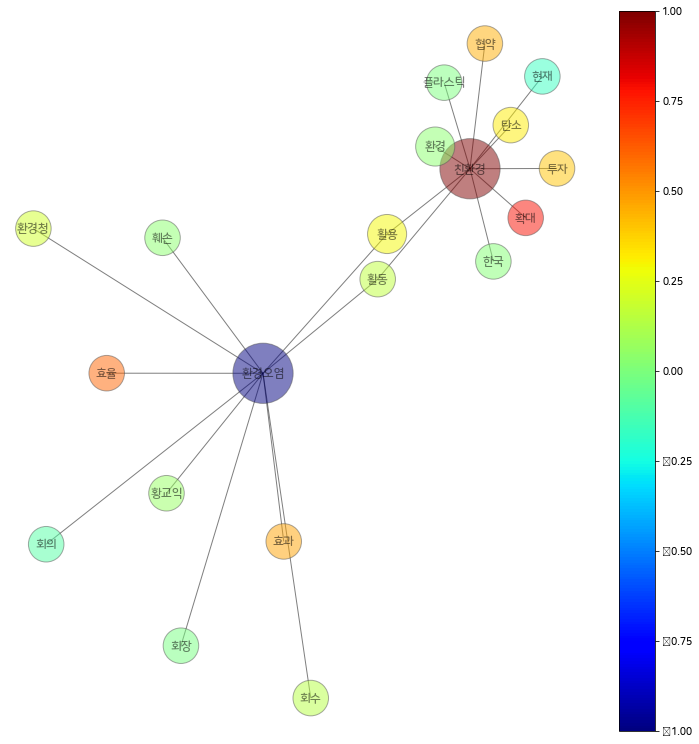

{'친환경': 0.8755390470036504,
 '환경오염': -1.0,
 '환경': -0.0327941241863218,
 '활용': 0.2149268762763713,
 '활동': 0.0846661601927674,
 '탄소': 0.2376015180305281,
 '플라스틱': -0.0639588582808797,
 '확대': 0.6765840980340457,
 '한국': -0.0465935028542133,
 '투자': 0.3164055175554887,
 '협약': 0.3623335436280854,
 '현재': -0.2212696144837213,
 '효과': 0.3803352934754587,
 '황교익': 0,
 '훼손': -0.0269567162176774,
 '효율': 0.5054748541291073,
 '회장': -0.0720975346207267,
 '회수': 0.0722558564686179,
 '회의': -0.1571551634215949,
 '환경청': 0.1343281249660061}

In [35]:
draw(news_data, sent_dict, ['환경오염','친환경'],10)